In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np

In [2]:
import json
from nltk import word_tokenize

with open('../data/partijen-metadata.json', 'r') as f:
     meta = json.load(f)

party_dict = {}
for party_data in meta['partijen']:
    party_id = party_data['lijst']
    party_name = party_data['naam'].encode('utf-8')
    party_dict["{:02d}".format(party_id)] = party_name
    
raw = pd.read_csv('../data/processed/dataframe.csv') 
raw['file'] = raw['file'].replace(to_replace=party_dict, regex=True).apply(lambda x: x.split('-')[1])
raw.rename(columns={'file': 'party'}, inplace=True)

party_labels = raw['party']
n_parties = len(party_labels)

def chunk_string(string, length):
    return [string[0+i:length+i] for i in range(0, len(string), length)]

df = raw['text'].apply(lambda x: pd.Series(chunk_string(x, length=600))).stack().reset_index()
df.rename(columns={0: 'text', 'level_0': 'party', 'level_1': 'snippet'}, inplace=True)

print "{:d} text snippets".format(len(df))
print "{:d} charachters in corpus".format(df['text'].apply(len).sum())
print "{:d} words in corpus".format(df['text'].apply(lambda x: word_tokenize(x, language='dutch')).apply(len).sum())
df.head()

4897 text snippets
2931367 charachters in corpus
418936 words in corpus


,party,snippet,text
0,0,0,n e d n o b r e v n ee g n i v e l sa m e n ve...
1,0,1,twerp paul pollmann inhoudsopgave essay ee...
2,0,2,rismebestrijding privacy justitie en rechtstaa...
3,0,3,ing werk en gezin pensioenen werkende ouderen ...
4,0,4,iedereen publieke waarden centraal van marktw...


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

from nltk.corpus import stopwords
from nltk.stem.snowball import DutchStemmer

stemmer = DutchStemmer()
def tokenize(text):
    """Converts text to tokens."""
    tokens = word_tokenize(text, language='dutch')
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

n_topics = 100

preproc_steps = [('vectorizer', TfidfVectorizer(input='content', encoding='utf-8',
                                                decode_error='strict', strip_accents=None,
                                                lowercase=True, preprocessor=None, tokenizer=tokenize,
                                                analyzer='word', stop_words=stopwords.words('dutch'), 
                                                ngram_range=(1, 3), max_df=0.5, min_df=1, max_features=None,
                                                vocabulary=None, binary=False, dtype=np.int64,
                                                norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)),
                 
                 ('topic_model', TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=10, random_state=12, tol=0.0))]

# balanced priors for Naive Bayes
equal_priors = np.ones(n_parties) /  np.float64(n_parties)
equal_priors[0] = equal_priors[0] + (1 - equal_priors.sum())

# specification of different model types and their defaults
model_steps_dict = {'nb': [('nb', GaussianNB(priors=equal_priors))],
                    'rf': [('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=32))],
                    'lr': [('lr', LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='lbfgs'))],
                   'dummy': [('dummy', DummyClassifier(strategy='prior', random_state=11))]}

# extract data from data frame
X = df['text'].values 
y = np.array(df['party'])

evaluate = True
if evaluate:
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=1)  # note that stratification doesnt work with native multiclass
    for model_type in model_steps_dict.keys():
        model_steps = model_steps_dict[model_type]
        estimator = Pipeline(steps=(preproc_steps + model_steps))
        scores = cross_val_score(estimator, X, y, cv=cv)
        print "Average {:s} classifier score: {:.4f} ".format(model_type, np.mean(scores))

# fit on whole data set
model_steps = model_steps_dict['lr']
estimator = Pipeline(steps=(preproc_steps + model_steps))
estimator.fit(X, y)
estimator

Average dummy classifier score: 0.1388 
Average nb classifier score: 0.3748 
Average lr classifier score: 0.5136 
Average rf classifier score: 0.4463 


Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=Tru...',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False))])

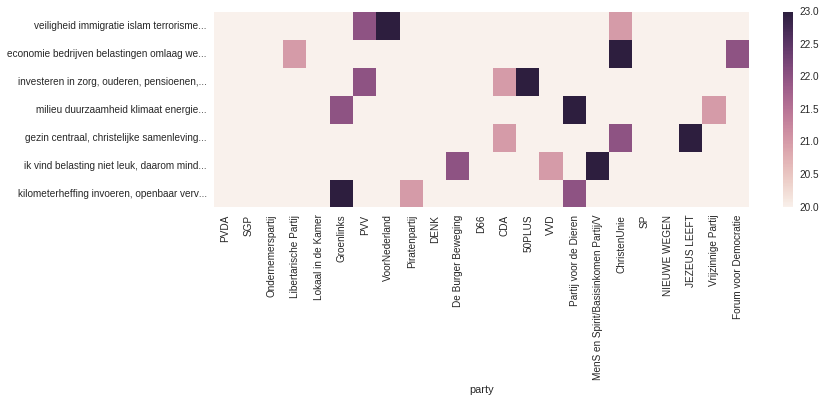

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_predictions(results):
    figsize=(12, .5 * len(results))
    fig, ax = plt.subplots(figsize=figsize)   
    sns.heatmap(results, ax=ax)
    ax.set_ylabel('')
    
def classify_text(estimator, texts, norm=None):
    pred_proba = estimator.predict_proba(texts)
    capped_texts = map(lambda x: x[:40] + '...', texts)
    results = pd.DataFrame(pred_proba, columns=[party_labels], index=capped_texts)
    if norm=='rank':
        results = results.rank(axis=1, ascending=True)
    if norm=='top3':
        results = results.rank(axis=1, ascending=True).applymap(lambda x: n_parties-3 if x<=(n_parties-3) else x)
    plot_predictions(results)

texts = ['veiligheid immigratie islam terrorisme',
         'economie bedrijven belastingen omlaag werkgelegenheid',
         'investeren in zorg, ouderen, pensioenen, pensioensleeftijd terug',
         'milieu duurzaamheid klimaat energie',
         'gezin centraal, christelijke samenleving, landbouw subsidies',
         'ik vind belasting niet leuk, daarom minder belasting, ik wil ook graag goedkoop auto rijden, bovendien moet werken lonen',
         'kilometerheffing invoeren, openbaar vervoer stimuleren, natuur beschermen']

classify_text(estimator, texts, norm='top3')

In [77]:
# function for multilabel format
def extract_probas(pred_proba):
    return np.array(map(lambda x1: map(lambda x2: x2[1], x1), pred_proba)).transpose()